In [43]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import sys
import imodels
import notebook_helper
import imodelsx.process_results
from collections import defaultdict
sys.path.append('../experiments/')
results_dir = '../results/linear/'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/02_train_linear.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
r['r2_gap'] = r['r2_train'] - r['r2_test']
# r.to_pickle('../results/agg.pkl')
# imodelsx.process_results.delete_runs_in_dataframe(r[r.use_bagging_ensemble == 1], actually_delete=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 270/270 [00:00<00:00, 3536.16it/s]


### Look at pred performance

In [44]:
d = r
for k in ["seed"]: #, "dataset_name"]:
    d = imodelsx.process_results.average_over_seeds(
        d, experiment_filename, key_to_average_over=k
    )

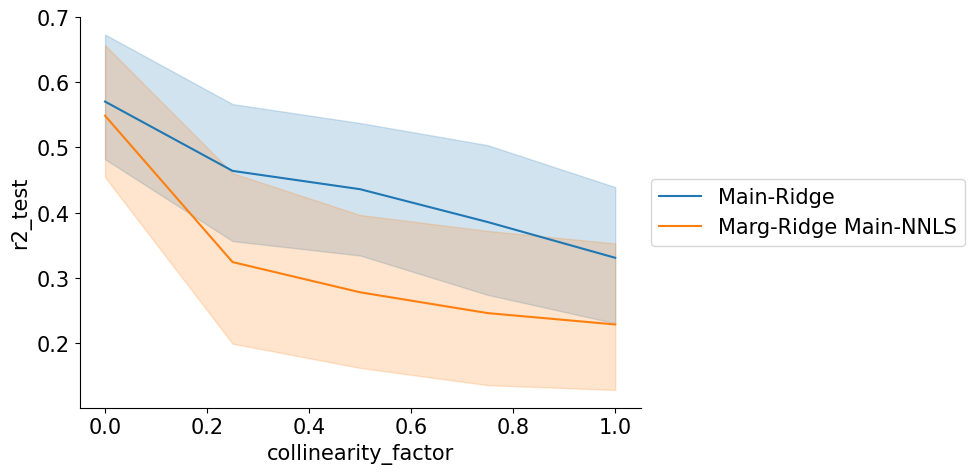

In [47]:
d["legend"] = (
    d["est_marginal_name"].map({"None": "", "ridge": "Marg-Ridge "})
    + d["use_marginal_divide_by_d"].map({0: "(no div) ", 1: ""})
    + d["est_main_name"].map({"None": "", "ridge": "Main-Ridge", 'NNLS': 'Main-NNLS'})
)

fig, ax = plt.subplots(figsize=(10, 5))
x = 'collinearity_factor' # 'train_frac', 'y_train_noise_std', 'collinearity_factor'
# sns.lineplot(data=r, x="train_frac", y="r2_test", hue="legend", markers=True)
sns.lineplot(data=d, x=x, y="r2_test", hue="legend", markers=True)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# plt.yscale("log")
plt.show()

/tmp/ipykernel_3789785/1859000009.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d2 = d[r.train_frac >= 0.8]


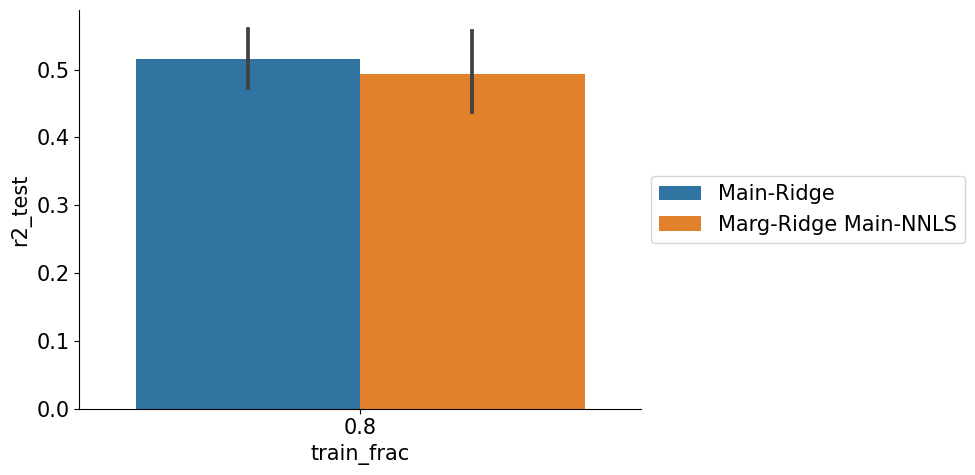

In [49]:
d2 = d[r.train_frac >= 0.8]
d2 = d2[d.r2_test >= 0.3]
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=d2, x="train_frac", y="r2_test", hue="legend")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

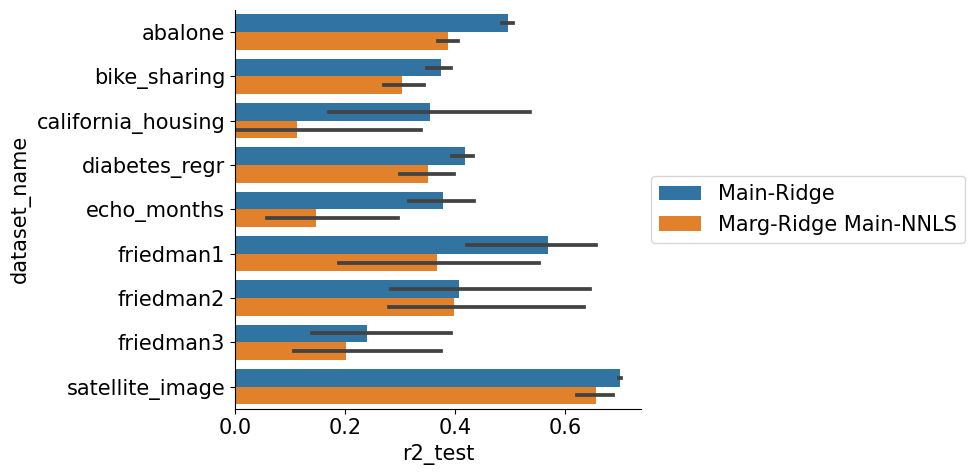

In [52]:
# d = r[r.train_frac >= 0.8]
# d = r[r.train_frac <= 0.3]
# d = d[d.r2_test >= 0.3]
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=d, y= "dataset_name", x="r2_test", hue="legend")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Analyze coefs between different runs

In [48]:
imodelsx.process_results.get_experiment_keys(r, experiment_filename)

['dataset_name',
 'est_marginal_name',
 'est_main_name',
 'use_marginal_sign_constraint',
 'collinearity_factor']

In [35]:
d = r
d = d[d.seed == 1]
d = d[d.use_marginal_divide_by_d == 1]
d = d[d.collinearity_factor == 0.0]

In [40]:
df = defaultdict(list)
for idx, g in d.groupby(
    [
        "dataset_name",
        # "est_marginal_name",
        # "est_main_name",
    ]
):
    coef_marg = g[(g.est_marginal_name == "ridge") & (g.est_main_name == 'None')].coef.values[0]
    coef_main = g[(g.est_marginal_name == "None") & (g.est_main_name == 'ridge')].coef.values[0]
    coef_both = g[(g.est_marginal_name == "ridge") & (g.est_main_name == 'ridge')].coef.values[0]

    df['dataset_name'].append(idx[0])
    # display(g)
    df['sign_agreement_0_shrinkage'].append(np.mean(np.sign(coef_marg) == np.sign(coef_main)))
    df['sign_agreement_marg_shrinkage'].append(np.mean(np.sign(coef_marg) == np.sign(coef_both)))
    # print(coef_marg, coef_main)
    # break

In [41]:
pd.DataFrame(df)

,dataset_name,sign_agreement_0_shrinkage,sign_agreement_marg_shrinkage
0,abalone,0.500000,0.500000
1,bike_sharing,0.916667,0.916667
2,california_housing,0.750000,0.750000
3,diabetes_regr,0.600000,0.600000
4,echo_months,0.888889,0.888889
5,friedman1,0.700000,0.700000
6,friedman2,0.750000,0.750000
7,friedman3,0.750000,0.750000
8,satellite_image,0.916667,0.916667
